<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Цель исследования**

- построить модель для предсказания количества заказов такси на следующий час для компании «Чётенькое такси».

**Описание данных:**

для проведения анализа представлен файл, содержащий исторические данные о заказах такси в аэропортах:

- */datasets/taxi.csv*.

**Количество заказов находится в столбце 'num_orders'.** 

**Заказчику важны:**

- значение метрики RMSE на тестовой выборке должно быть не больше 48.

**План работы:**

1. загрузить данные и выполнить их ресемплирование по одному часу;
2. проанализировать данные;
3. обучить разные модели с различными гиперпараметрами (тестовую выборку сделать размером 10% от исходных данных);
4. проверить данные на тестовой выборке; 
7. написать общий вывод.   

## Подготовка

На этом этапе мы загрузим данные из представленного файла в датафрейм, изучим полученную информацию и проведем ресемплирование по одному часу.

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (GridSearchCV, train_test_split, TimeSeriesSplit)
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

In [2]:
# загружаем данные из файла в датафрейм и выводим основную информацию о датафрейме с помощью метода info()
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Как мы видим, в нашем датафрейме 2 столбца и 26 496 строк. Данные в столбце datetime выражены строковым типом, а в столбце num_orders (т.е. количество заказов) - целочисленным. На следующем шаге изменим тип данных в столбце datetime на тип datetime64.
Названия столбцов соответствует требованиям "змеиного регистра", здесь менять ничего не будем. Количество строк в столбцах соответствует, что может говорить об отсутствии пропусков данных. Проверку на пропуски мы проведем на этапе 2 ("Анализ").

In [3]:
# загружаем данные из файла в датафрейм, изменяем тип данных с object на datetime64 с помощью аргумента parse_dates
# и устанавливаем индекс таблицы с помощью index_col
data = pd.read_csv(r'https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
# проверяем соблюдение хронологического порядка
#data.index.is_monotonic - не работает, см. ниже

In [4]:
data.index.is_monotonic_increasing

True

Атрибут вернул True, т.е. хронологический порядок соблюден.

In [5]:
# выполняем ресемплирование данных по одному часу
data = data.resample('1H').sum()

In [6]:
# выводим основную информацию о датафрейме с помощью метода info()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Как видим, ресемплирование прошло успешно. В нашем датафрейме имеются данные за период с 01 марта 2018 по 31 августа 2018.

Таким образом, на данном этапе мы провели следующую работу:
- загрузили данные из представленного файла в датафрейм;
- изучили полученную информацию;
- изменили тип данных в столбце datetime на тип datetime64 и расположили данные в хронологическом порядке;
- провели ресемплирование по одному часу.

Теперь перейдем к анализу данных.

## Анализ

In [7]:
# выведем первые 20 строк датафрейма на экран
data.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Видим, что данные расположены в хронологическом порядке. Каждой дате соответствует суммарное количество заказов такси. Пропусков в данном фрагменте нет.

In [8]:
# проверим количество пропусков в % 
pd.DataFrame(round(data.isna().mean()*100,).sort_values(ascending=False)).style.background_gradient('coolwarm')

,0
num_orders,0.000000


Пропуски отсутствуют. Проведение проверки на наличие дубликатов лишено целесообразности: datetime является индексным столбцом, индексы уникальные (соблюдение хронологического порядка проверено выше), по сути у нас есть только один столбец с числовыми значениями.
Посмотрим на распределение.

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


Видим, что минимальное количество заказов равно нулю, максимум - это 426, медиана 125 и среднее 130. Нереалистичные значения/аномалии отсутствуют.

Теперь построим график.

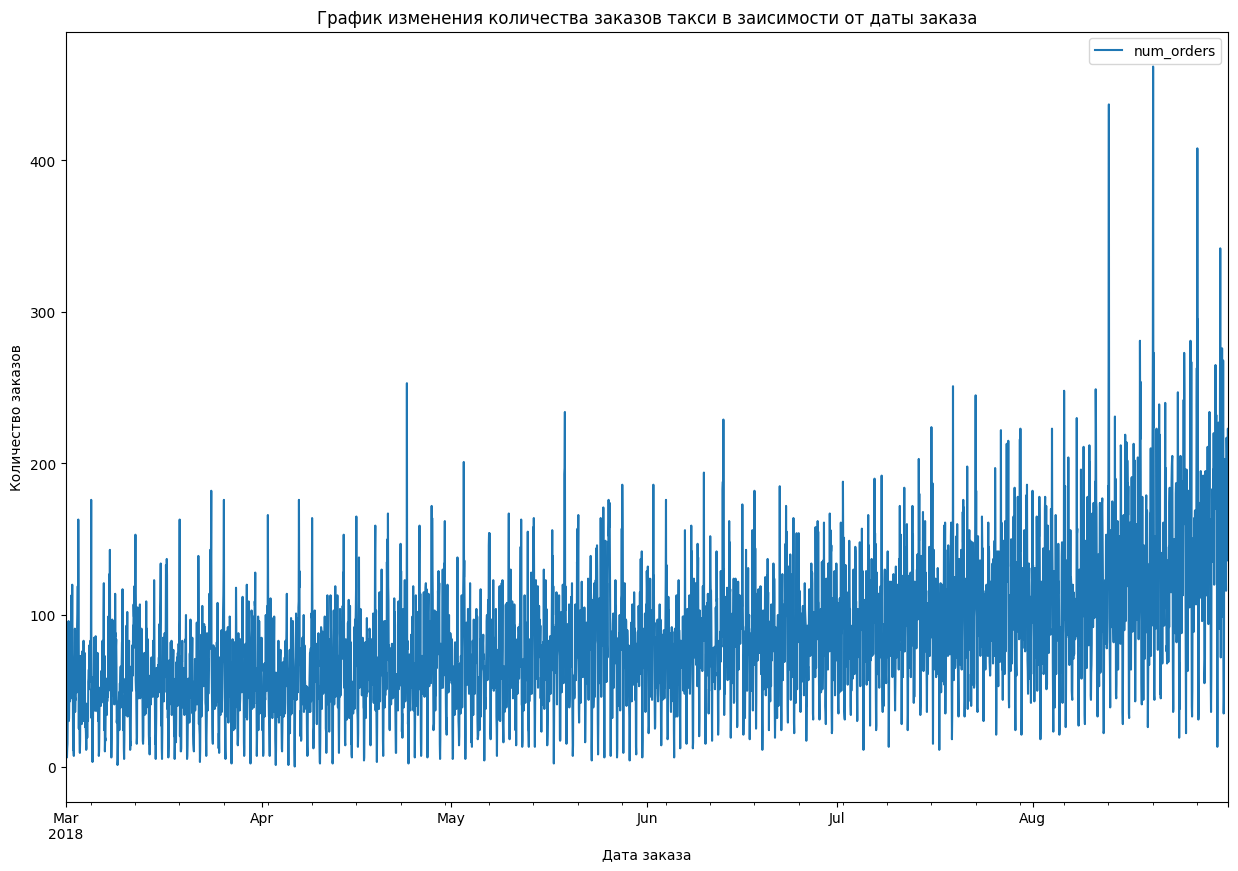

In [10]:
data.plot(figsize=(15, 10))
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов')
plt.title('График изменения количества заказов такси в заисимости от даты заказа')
plt.show()

Чтобы снизить колебания во временном ряду, применим скользящее среднее и отразим его на графике.

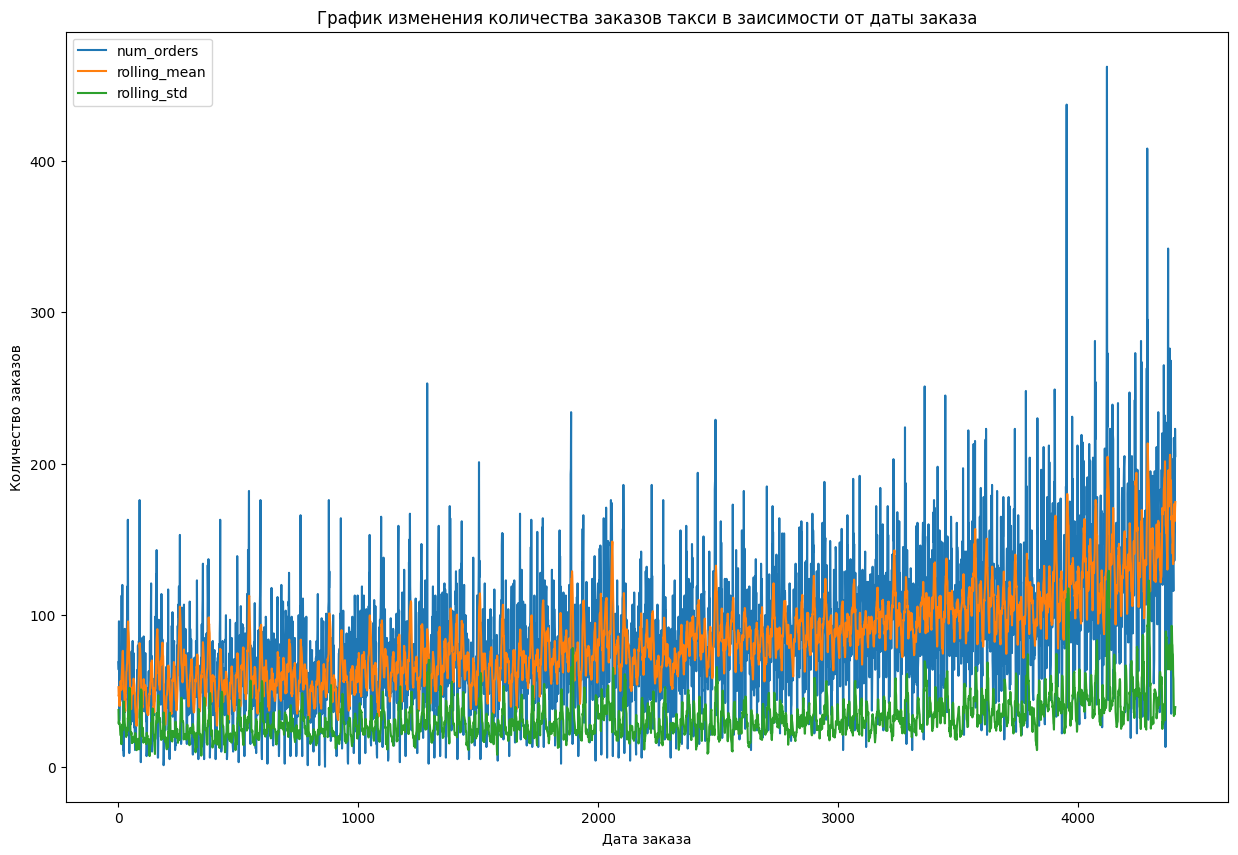

In [11]:
data_1 = data.copy()
data_1['rolling_mean'] = data_1['num_orders'].rolling(10).mean()
data_1['rolling_std'] = data_1['num_orders'].rolling(10).std()
data_1 = data_1.dropna(subset=['rolling_mean', 'rolling_std']).reset_index(drop=True)
data_1.plot(figsize=(15, 10))
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов')
plt.title('График изменения количества заказов такси в заисимости от даты заказа')
plt.show()

Начиная с марта и по конец августа наблюдаем рост количества заказов такси при наличии нескольких спадов в данный период. Это видно по кривой rolling_mean. Теперь посмотрим на **график для разности временного ряда** (ее используют, чтобы сделать ряд сделать стационарным, что важно для прогнозирования).

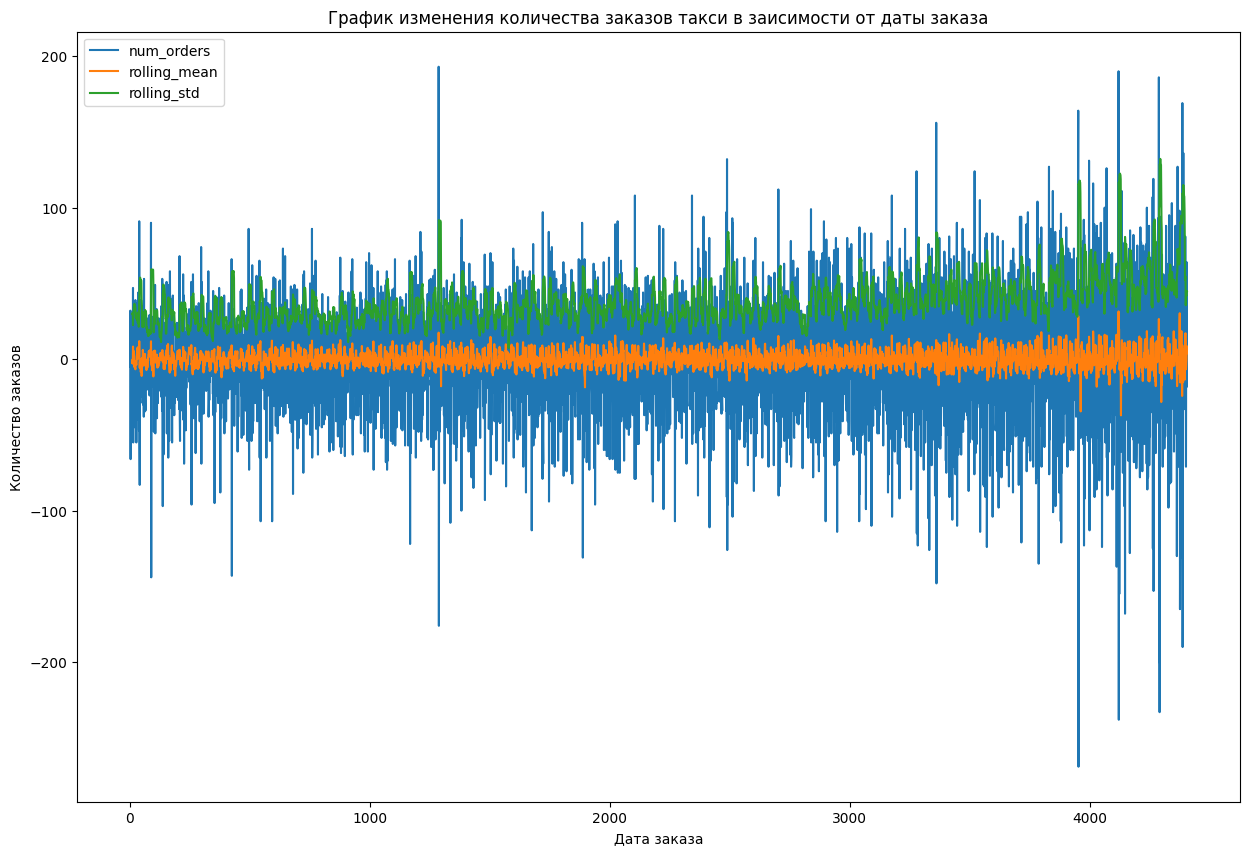

In [12]:
data_1 = data_1 - data_1.shift()
data_1['rolling_mean'] = data_1['num_orders'].rolling(10).mean()
data_1['rolling_std'] = data_1['num_orders'].rolling(10).std()
data_1.plot(figsize=(15, 10))
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов')
plt.title('График изменения количества заказов такси в заисимости от даты заказа')
plt.show()

Теперь разложим наш временной ряд на тренд и сезонную компоненту.

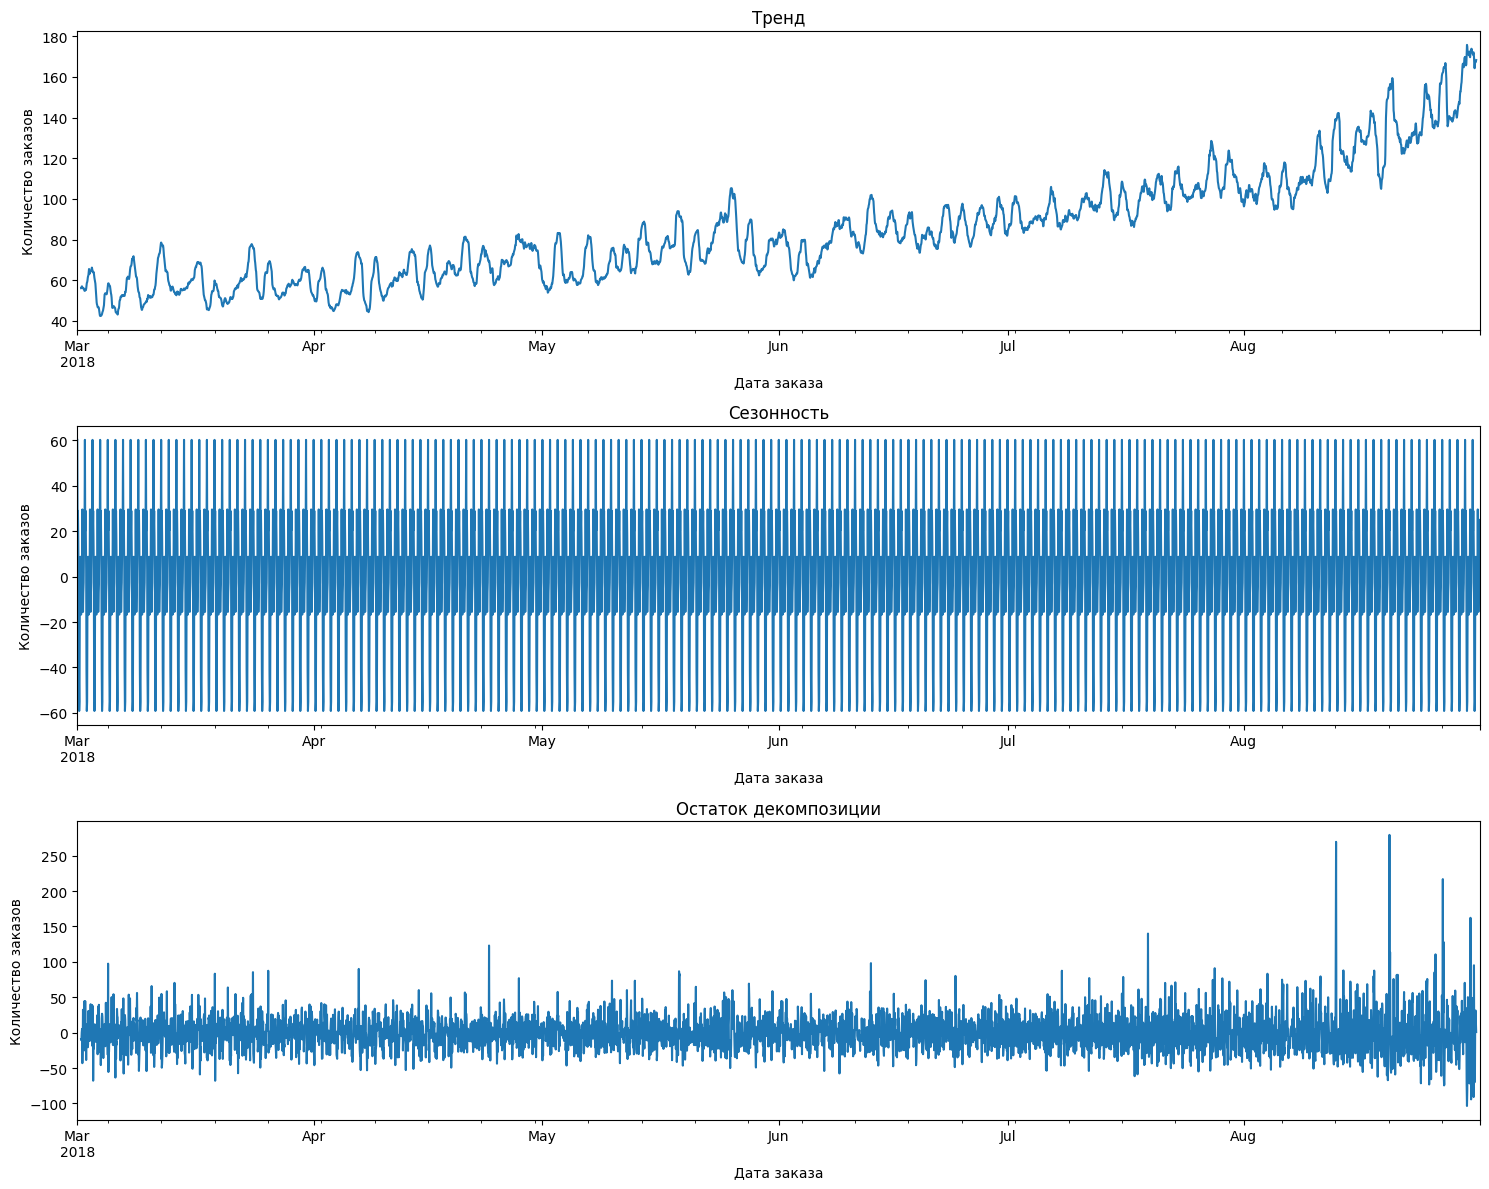

In [13]:
# для корректного разложения на тренд и сезонную компоненту загрузил данные заново
# без этого код выдает ошибку "ValueError: You must specify a period or x must be 
# a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None"
# после повторной загрузки код выполняется корректно
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

decomposed = seasonal_decompose(data)
plt.figure(figsize=(15, 12))
plt.subplot(311)
#plt.gca() - получить текущие оси, необходимо для корректного отображения графика
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов')
plt.tight_layout()

Тренд — плавное изменение среднего значения ряда без повторяющихся закономерностей. 
Сезонность — циклично повторяющиеся закономерности во временном ряду.

Как видно на графиках выше, имеется тренд на увеличение количества заказов такси на протяжении всего рассматриваемого периода. Сезонных изменений мы не видим. Скорее всего, это связано с тем, что имеются данные за только период с 01 марта 2018 по 31 августа 2018. Т.е. масштаб наших данных невелик. 

Таким образом, на данном этапе мы провели следующую работу:

- осуществили проверку датафрейма на наличие пропусков (пропусков не обнаружено);
- посмотрели на распределение количества заказов такси (минимальное количество заказов равно нулю, максимум - это 426, медиана 125 и среднее 130; нереалистичные значения/аномалии отсутствуют);
- построили графики изменения количества заказов такси в заисимости от даты заказа, применили скользящее среднее, построили график для разности временного ряда, разложили наш временной ряд на тренд и сезонную компоненту;
- установили, что имеется тренд на увеличение количества заказов такси на протяжении всего рассматриваемого периода. Сезонных изменений мы не видим. Скорее всего, это связано с тем, что имеются данные за только период с 01 марта 2018 по 31 августа 2018. Т.е. масштаб наших данных невелик.

## Обучение

На данном этапе мы создадим признаки и проведем разделение на выборки, а затем обучим несколько моделей и сравним их метрики RMSE.

In [14]:
# функция для создания признаков: создаем календарные признаки и «отстающие значения» (lag features)
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() 

In [15]:
# задаем количество отстающих значений: 30 и скользящее среднее: 7 
# нужное значение метрики RMSE достигается именно при таких параметрах
make_features(data, 30, 7)

In [16]:
# разделяем на выборки
train, test = train_test_split(data, shuffle=False, test_size=0.10, random_state=12345)
train = train.dropna()
print(train.shape)
print(test.shape)

(3944, 36)
(442, 36)


In [17]:
X_train = train.drop(['num_orders'], axis = 1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis = 1)
y_test = test['num_orders']

print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-02 06:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [18]:
# масштабируем
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# оценим качество модели предыдущим значением ряда
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE:', mean_squared_error(test, pred_previous, squared=False))

RMSE: 51.429455790411915


По условиям проекта начение метрики RMSE на тестовой выборке должно быть не больше 48. Полученная метрика константной модели существенно хуже.

Теперь обучим модели. Условиями проекта не определено количество и вид моделей. Выберем Линейную регрессию, Случайный лес, CatBoost и LightGBM.

**Рассмотрим Линейную регрессию**

In [20]:
# задаем Time Series cross-validator
# будем использовать его для всех наших моделей
tscv = TimeSeriesSplit(n_splits=3)

In [21]:
%%time
lin = GridSearchCV(estimator=LinearRegression(), param_grid={
    }, scoring = 'neg_root_mean_squared_error', cv=tscv)
lin.fit(X_train, y_train)

print('Оптимальные значения параметров:', lin.best_params_)
print('RMSE:', lin.best_score_ *(-1))

Оптимальные значения параметров: {}
RMSE: 27.404463162810643
CPU times: total: 15.6 ms
Wall time: 41.3 ms


**Рассмотрим Случайный лес**

In [22]:
%%time
forest = GridSearchCV(estimator=RandomForestRegressor(random_state=12345), param_grid={ 
    'n_estimators': range(10, 110, 10),
    'max_depth': range(2, 15, 1)}, scoring = 'neg_root_mean_squared_error', cv=tscv)
forest.fit(X_train, y_train)

print('Оптимальные значения параметров:', forest.best_params_)
print('RMSE:', forest.best_score_ *(-1))

Оптимальные значения параметров: {'max_depth': 14, 'n_estimators': 100}
RMSE: 27.35301440725267
CPU times: total: 16min 44s
Wall time: 17min 14s


**Рассмотрим CatBoost**

In [23]:
%%time
cbr = GridSearchCV(estimator=CatBoostRegressor(loss_function='RMSE', silent=True, random_state=12345), param_grid={
    'iterations': range(20, 60, 10),'depth': range(5, 10, 2)}, scoring = 'neg_root_mean_squared_error', cv=tscv)
cbr.fit(X_train, y_train)

print('Оптимальные значения параметров:', cbr.best_params_)
print('RMSE:', cbr.best_score_ *(-1))

Оптимальные значения параметров: {'depth': 5, 'iterations': 50}
RMSE: 27.38825884321193
CPU times: total: 10.1 s
Wall time: 11.4 s


**Рассмотрим LightGBM**

In [24]:
%%time
gbm = GridSearchCV(estimator=LGBMRegressor(random_state=12345, force_col_wise=True), param_grid={ 
    'n_estimators': range(90, 110, 10),
    'num_leaves': range(20, 40, 10)}, scoring = 'neg_root_mean_squared_error', cv=tscv)
gbm.fit(X_train, y_train)

print('Оптимальные значения параметров:', gbm.best_params_)
print('RMSE:', gbm.best_score_ *(-1))

[LightGBM] [Info] Total Bins 3705
[LightGBM] [Info] Number of data points in the train set: 986, number of used features: 34
[LightGBM] [Info] Start training from score 57.051724
[LightGBM] [Info] Total Bins 4577
[LightGBM] [Info] Number of data points in the train set: 1972, number of used features: 34
[LightGBM] [Info] Start training from score 63.382353
[LightGBM] [Info] Total Bins 5232
[LightGBM] [Info] Number of data points in the train set: 2958, number of used features: 34
[LightGBM] [Info] Start training from score 70.008790
[LightGBM] [Info] Total Bins 3705
[LightGBM] [Info] Number of data points in the train set: 986, number of used features: 34
[LightGBM] [Info] Start training from score 57.051724
[LightGBM] [Info] Total Bins 4577
[LightGBM] [Info] Number of data points in the train set: 1972, number of used features: 34
[LightGBM] [Info] Start training from score 63.382353
[LightGBM] [Info] Total Bins 5232
[LightGBM] [Info] Number of data points in the train set: 2958, numb

Таким образом, наши модели показали следующие занчения метрики RMSE:

- Линейная регрессия: 27.404463162810643;
- Случайный лес: 27.35301440725267; 
- CatBoost: 27.38825884321193;
- LightGBM: 27.221435079602998.

Согласно условиям проекта RMSE модели не должно быть больше 48. Указанному условию удовлетворяют все использованнные модели и RMSE каждой из них лучше, чем у константной. При этом лучший показатель у LightGBM (27.221435079602998). Эту модель мы и выберем для проверки на тестовой выборке. 

## Тестирование

На предыдущем этапе по итогам проверки мы определили лучшую модель. Теперь проверим ее на тестовой выборке.

In [25]:
pred_gbm = gbm.best_estimator_.predict(X_test)
print('RMSE:', mean_squared_error(y_test, pred_gbm)**(1/2))

RMSE: 41.204021613436026


Значение метрики RMSE составило 41.204021613436026. Таким образом, цель проекта достигнута - получена модель, удовлетворяющая требованиям заказчика.

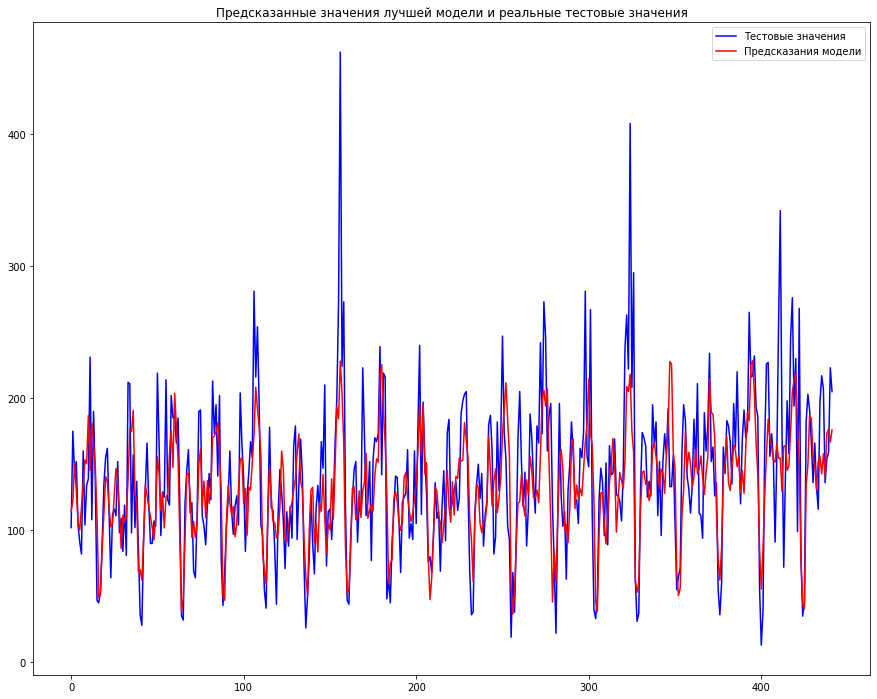

In [25]:
plt.figure(figsize=(15, 12))
plt.subplot()
plt.plot(range(len(y_test)), y_test, color='blue')
plt.plot(range(len(pred_gbm)), pred_gbm, color='red')
plt.title('Предсказанные значения лучшей модели и реальные тестовые значения')
plt.legend(['Тестовые значения','Предсказания модели'], loc=1)
plt.show()

## Общий вывод:

Целью нашего проекта было построить модель для предсказания количества заказов такси на следующий час для компании «Чётенькое такси».

Для проведения анализа был представлен следующий файл:

- */datasets/taxi.csv*.

**Количество заказов находится в столбце 'num_orders'.** 

**Заказчику важны:**

- значение метрики RMSE на тестовой выборке должно быть не больше 48.


На этапах "Подготовка" и "Анализ" мы провели следующую работу:

- загрузили данные из представленного файла в датафрейм;
- изучили полученную информацию;
- изменили тип данных в столбце datetime на тип datetime64 и расположили данные в хронологическом порядке;
- провели ресемплирование по одному часу;
- выяснили, что в нашем датафрейме имеются данные за период с 01 марта 2018 по 31 августа 2018;
- осуществили проверку датафрейма на наличие пропусков (пропусков не обнаружено);
- посмотрели на распределение количества заказов такси (минимальное количество заказов равно нулю, максимум - это 426, медиана 125 и среднее 130; нереалистичные значения/аномалии отсутствуют);
- построили графики изменения количества заказов такси в заисимости от даты заказа, применили скользящее среднее, построили график для разности временного ряда, разложили наш временной ряд на тренд и сезонную компоненту;
- установили, что имеется тренд на увеличение количества заказов такси на протяжении всего рассматриваемого периода. Сезонных изменений мы не видим. Скорее всего, это связано с тем, что имеются данные за только период с 01 марта 2018 по 31 августа 2018. Т.е. масштаб наших данных невелик.

На этапе "Обучение" мы выбрали и обучили четыре модели: Линейную регрессию, Случайный лес, CatBoost и LightGBM. **При проверке на обучающей выборке лучшее значение метрики RMSE показала модель LightGBM (27.221435079602998)**, что соответствует установленному в условиях проекта критерию (не больше 48) и лучше показателя константной модели (51.429455790411915). При проверке **на тестовой выборке мы получили значение метрики RMSE = 41.204021613436026**

Таким образом, цель проекта достигнута - получена модель, удовлетворяющая требованиям заказчика.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48